This Notebook is based on the Logisitic Regression model discussed during Andrew Ng's coursera MOOC [course](https://www.coursera.org/learn/machine-learning/home/welcome). The python coding is a shameless adaptation of the Kevin Davenport [blog](http://kldavenport.com/regularized-logistic-regression-intuition/)

In [65]:
import os
os.chdir(r'C:\Users\CDRONAVA\Downloads\machine-learning-ex2\machine-learning-ex2\ex2')
os.getcwd()

'C:\\Users\\CDRONAVA\\Downloads\\machine-learning-ex2\\machine-learning-ex2\\ex2'

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import seaborn as sns
from ggplot import *
%matplotlib inline

####Loading the data

In [67]:
#Load the training data
data = pd.read_csv('ex2data2.txt', header=None, names = ('x1','x2','y'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 3 columns):
x1    118 non-null float64
x2    118 non-null float64
y     118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.7 KB


Columns 1 & 2 are the training data, 3 is the label set

In [68]:
data.head()

,x1,x2,y
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [69]:
# Get the df values into numpy arrays
X = data.ix[:,0:2].values
y = data.ix[:,2].values
y = y[:, None]

###Visualizing the data



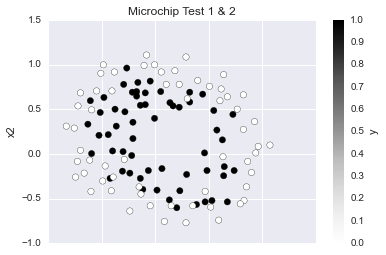

In [70]:
data.plot(kind='scatter', x=0, y=1, c=2, s=40, title='Microchip Test 1 & 2',
         figsize=None, legend=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001FF14748>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000205F9F60>]], dtype=object)

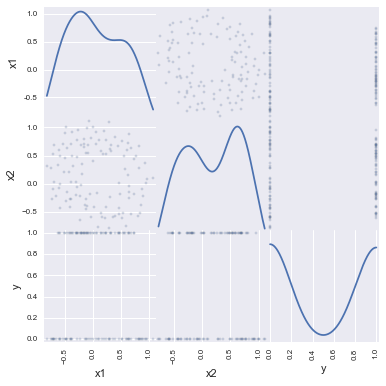

In [71]:
#in pandas
pd.scatter_matrix(data, alpha=0.2, figsize=(6, 6), diagonal='kde')

Beautiful plots using seaborn package

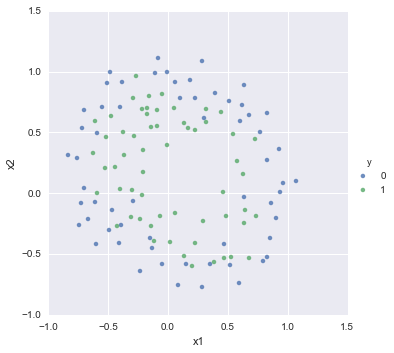

In [72]:
sns.lmplot('x1','x2', hue='y', data=data, fit_reg=False)

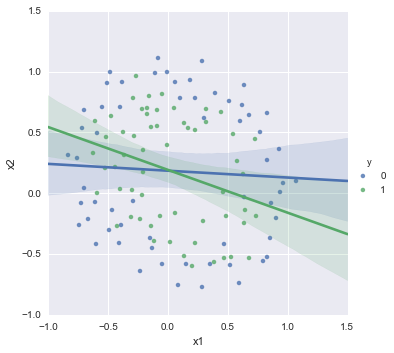

In [73]:
sns.lmplot('x1','x2', hue='y', data=data, fit_reg=True)

One more take on ggplot.

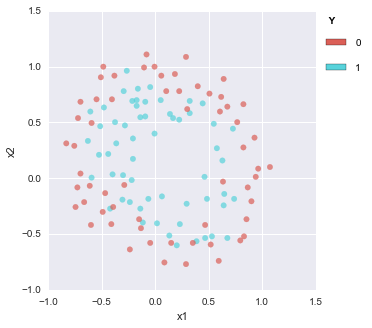

<ggplot: (34146269)>

In [74]:
ggplot(data, aes(x='x1',y='x2', color='y')) +\
    geom_point(alpha=0.7, size = 30) +\
    theme_matplotlib(rc={"figure.figsize":"6,5"})

We'll use logistic regression for binary classification. This means we'll be taking a continous range of input and convert it to either 0 or 1 based on its range: <br>

$h_\theta(x)$= Our Logistic Regression function. <br>
If the output of $h_\theta(x)\geq .5$, then 1<br>
If the output of $h_\theta(x)\lt .5$, then 0<br>

We'll have a vector of coefficients $\theta$ that we chose to get us as close of y(our labels) as possible, that is to say choose $\theta_0$, $\theta_1$, $\theta_2$ (assuming we only have three coefficients) that minimize the sum of the squared differences (squared error).

![caption](http://kldavenport.com/wp-content/uploads/2014/11/logisitic_regression_blog2.png "Matrix Examples") 

<br>
So it's a clean algebra process of : **Prediction = Data * Parameters**


Now we'll take our data and process it through the sigmoid function:
$$h_\theta(x) = g(\theta^Tx): g(z) = \frac{1}{1 + e^{-z}}$$

The logistic regression cost function including regularization (last term) is:

$$J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m} [-y^{(i)}log(h_\theta(x^{(i)})-(1 - y^{(i)})log(1 - h_\theta(x^{(i)}))]+\frac{\lambda}{2m}\sum\limits_{j=1}^{n}\theta^2_j$$

The gradient of the cost including regularization is:

$$\frac{\partial{J(\theta)}}{\partial{\theta_j}} = \frac{1}{m}\sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}     \qquad \qquad \qquad   for \,\, j=0 $$

$$\frac{\partial{J(\theta)}}{\partial{\theta_j}} = (\frac{1}{m}\sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) + \frac{\lambda}{m}\theta_j    \qquad    for \,\, j \geq 1 $$

###Feature Engineering:

We can tell from the two-dimensional plots above that we have non-linearly seperable data. We might want to start with seeing what kind of boundaries we can train using interactions between the two varibles in our feature space. Since we're using logistic regression we'll need to manually construct these new features. This is not the case with more advanced non-linear methods such as SVMs with a Gaussian or polynomial kernal as the various interactions between the input variables are inherently captured by the structure of the model.

Remember that depending on the scale of the new features we create (e.g. X1, X2, X1^2, X2^2, X1\*X2, X1\*X2^2), we might need to scale down variables to speed up convergence of the gradient descent. Logistic Regression, like SVMs can also suffer poor performance if some input variables have a larger range of values compared to others. Normalization is used to address this: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing.

In [75]:
def new_features(X1, X2, degree=18):
    """
    Returns a m x n matrix of the original inputs along with new columns based on their exponents and combinations.
    Args:
        x1, x2: 2D arrays (floats) with identical shapes
        highest_poly_degree: int to specify the max polynomial
    """    
    num_features = (degree + 1) * (degree + 2) / 2
    out = np.empty(shape=(X1.shape[0], num_features), dtype=float)
    k = 0
    for i in xrange(0, degree + 1):
        for j in xrange(i + 1):
            new_feature_values = X1**(i - j) * X2**j
            out[:, k] = new_feature_values[:, 0]
            k += 1
    return out

In [76]:
X = new_features(X[:, 0][:, None], X[:, 1][:, None])

In [77]:
X.shape

(118L, 190L)

$g(z) = \frac{1}{1+e^{-z}}$ expressed as:

In [78]:
def sigmoid(z):
    """
    Return Sigmoid of z
    Args:
        Z : array or scalar
    """
    return 1.0 / (1.0 + np.exp(-z))

Usually we'd want to use a package function. Notice above that we are using numpy's exp and not the math library's exp. There is a common performance hit in Python code of accidentally bouncing back and forth between NumPy and standard functions which are not optimized for the contiguous C arrays of NumPy.

Below we are using SciPy's expit over scipy.stats.logistic.cdf because it is the source operator and not a wrapper function with extra parameters like logistic.cdf. Note the 4x speedup between our manual and SciPy function.

In [79]:
from scipy.special import expit

In [80]:
%%timeit

expit([X[1]])

The slowest run took 9.06 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 6.89 Âµs per loop


In [81]:
%%timeit

sigmoid(X[1])

The slowest run took 6.14 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 7.49 Âµs per loop


$g(\theta^Tx)$ expressed as:

In [82]:
def h_of_theta(theta, X):
    transposed_theta = theta[:, None]
    return sigmoid(X.dot(transposed_theta))

$J(\theta) = \frac{1}{m}\sum\limits_{i=1}^{m} [-y^{(i)}log(h_\theta(x^{(i)})-(1 - y^{(i)})log(1 - h_\theta(x^{(i)}))]+\frac{\lambda}{2m}\sum\limits_{j=1}^{n}\theta^2_j$ <br>

Recall that the $\frac{\lambda}{2m}\sum\limits_{j=1}^{n}\theta^2_j$ at the end of the line above is the regularization term.<br>
expressed as:

In [83]:
def cost_function_reg(theta, X, y, lamda):
    """
    Return cost of given theta for logistic regression
    Args:
        theta is a 1D numpy array 
        X is a m x n numpy array w/ the first column being an intercept of 1
        y is a m x 1 numpy array, it is the label set for each obs in X
        lambda : float is regularization parameter
    """
    m = len(y) * 1.0
    h_theta = h_of_theta(theta, X)


    tol = .00000000000000000000001  
    h_theta[h_theta < tol] = tol  # values close to zero are set to tol
    h_theta[(h_theta < 1 + tol) & (h_theta > 1 - tol)] = 1 - tol  # values close to 1 get set to 1 - tol

    regularization_term = (float(lamda)/2) * theta**2
    cost_vector = y * np.log(h_theta) + (-y + 1) * np.log(-h_theta + 1)

    J = -sum(cost_vector)/m + sum(regularization_term[1:])/m

    return J[0]

$\frac{\partial{J(\theta)}}{\partial{\theta_j}} = \frac{1}{m}\sum\limits_{i=1}^{m}(h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)} \qquad \qquad \qquad  for \,\, j =0$

$\frac{\partial{J(\theta)}}{\partial{\theta_j}} = (\frac{1}{m}\sum\limits_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}) + \frac{\lambda}{m}\theta_j    \qquad    for \,\, j \geq 1 $ expressed as:

In [84]:
def gradient(theta, X, y, lamda):
    """
    Return gradient of theta 
    Args:
        theta is a 1D numpy array 
        X is a m x n numpy array w/ the first column being an intercept of 1
        y is a m x 1 numpy array, it is the label set for each obs in X
        lambda : float is regularization parameter
    """
    m = len(y)
    h_theta = h_of_theta(theta, X)
    derivative_regularization_term = float(lamda) * theta/m
    grad = (h_theta - y).T.dot(X)/m + derivative_regularization_term.T
    grad[0][0] -= derivative_regularization_term[0]  
    print grad
    
    return np.ndarray.flatten(grad)

Let's see what we have so far and test one iteration of regularized logistic regression at initial theta

In [85]:
m, n = X.shape
initial_theta = np.zeros(n)
lambda2=1

cost = cost_function_reg(initial_theta, X, y, lambda2)
grad = gradient(initial_theta, X, y, lambda2)

print 'Training set size: ', X.shape
print ''
print 'Cost at initial theta of zeros:',cost
print '\nGradient at initial theta (zeros):\n'
print grad

[[  8.47457627e-03   1.87880932e-02   7.77711864e-05   5.03446395e-02
    1.15013308e-02   3.76648474e-02   1.83559872e-02   7.32393391e-03
    8.19244468e-03   2.34764889e-02   3.93486234e-02   2.23923907e-03
    1.28600503e-02   3.09593720e-03   3.93028171e-02   1.99707467e-02
    4.32983232e-03   3.38643902e-03   5.83822078e-03   4.47629067e-03
    3.10079849e-02   3.10312442e-02   1.09740238e-03   6.31570797e-03
    4.08503006e-04   7.26504316e-03   1.37646175e-03   3.87936363e-02
    1.99427086e-02   2.74239681e-03   2.32500787e-03   2.21859968e-03
    1.37054473e-03   4.59059364e-03   2.44887343e-03   3.45775396e-02
    2.58470812e-02   9.24073316e-04   3.56449986e-03   2.36431492e-04
    2.73345994e-03   1.41372690e-04   5.06220460e-03   7.44299593e-04
    3.91158180e-02   1.94460178e-02   2.03971305e-03   1.67313910e-03
    9.57374855e-04   8.28510751e-04   1.45754709e-03   5.55440822e-04
    3.80878101e-03   1.42922173e-03   3.74400380e-02   2.27382094e-02
    1.00011095e-03  

###Finding the optimal theta
[scipy.optimize](http://docs.scipy.org/doc/scipy-0.14.0/reference/optimize.html) contains SciPy's the optimization and root finding methods. In this instance we'll use fmin_bfgs to minimize our function using the BFGS algorithm. We're doing with BFGS is approximating Newton's method, which is an iterative method applied to the derivative(slope) of a function to find zeros. As you can see we're digging just a little deeper than simply calling `fit, predict, score, transform` in sci-kit learn


In [86]:
# set options then run fmin_bfgs to obtain optimal theta (BFGS: quasi- Newton method of Broyden, Fletcher, Goldfarb, and Shanno)

initial_theta = np.zeros(n)
lambda2 = 1

myargs = (X, y, lambda2)
opts ={'full_output':True, 'maxiter': 400}

optimal_theta, cost, grad_at_min, inv_hessian_matrix,\
fun_calls, grad_calls, warn_flags = optimize.fmin_bfgs(cost_function_reg,\
                                                      initial_theta,
                                                      args = myargs,
                                                      fprime=gradient,
                                                      **opts)


print '\nCost at theta found by fmin_bfgs:', cost
print '\noptimal theta:'
print optimal_theta

[[  8.47457627e-03   1.87880932e-02   7.77711864e-05   5.03446395e-02
    1.15013308e-02   3.76648474e-02   1.83559872e-02   7.32393391e-03
    8.19244468e-03   2.34764889e-02   3.93486234e-02   2.23923907e-03
    1.28600503e-02   3.09593720e-03   3.93028171e-02   1.99707467e-02
    4.32983232e-03   3.38643902e-03   5.83822078e-03   4.47629067e-03
    3.10079849e-02   3.10312442e-02   1.09740238e-03   6.31570797e-03
    4.08503006e-04   7.26504316e-03   1.37646175e-03   3.87936363e-02
    1.99427086e-02   2.74239681e-03   2.32500787e-03   2.21859968e-03
    1.37054473e-03   4.59059364e-03   2.44887343e-03   3.45775396e-02
    2.58470812e-02   9.24073316e-04   3.56449986e-03   2.36431492e-04
    2.73345994e-03   1.41372690e-04   5.06220460e-03   7.44299593e-04
    3.91158180e-02   1.94460178e-02   2.03971305e-03   1.67313910e-03
    9.57374855e-04   8.28510751e-04   1.45754709e-03   5.55440822e-04
    3.80878101e-03   1.42922173e-03   3.74400380e-02   2.27382094e-02
    1.00011095e-03  

We've found a set of theta that allows us to get the cost down to ~0.52 from the ~0.69 we saw above in our initial thetas of zero. 

Let's reuse one of our plotting methods earlier (in this case seaborn) in this notebook and draw the decision boundry over it. Thanks to [github user Nonnormalizable](https://github.com/Nonnormalizable/NgMachineLearningPython/blob/master/ex2/helperFunctions.py) for the boundry code.

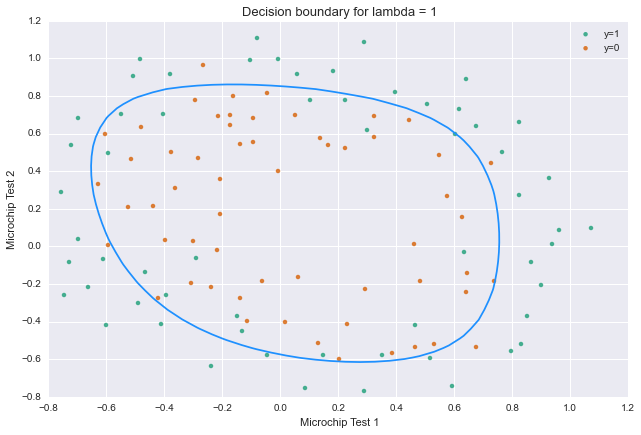

In [87]:
def plot_decision_boundary(theta, X, y):
    # Simple seaborn scatterplot
    sns.lmplot('x1','x2',hue='y',data=data,fit_reg=False,size = 6,aspect= 1.5,palette='Dark2',legend=False)
    
    z = np.zeros([50, 50])
    uu = np.linspace(-1.0, 1.5, 50)
    vv = np.linspace(-1.0, 1.5, 50)
    for i, u in enumerate(uu):
        for j, v in enumerate(vv):
            z[i, j] = np.dot(new_features(np.array([[u]]), np.array([[v]])), theta)[0]
    plt.contour(uu, vv, z.T, [0], colors='dodgerblue')
    plt.axis([-.8, 1.2, -.8, 1.2])
    plt.xticks(np.arange(-.8, 1.3, .2))
    plt.yticks(np.arange(-.8, 1.3, .2))
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend(('y=1', 'y=0'), loc='upper right', numpoints=1)
    plt.title('Decision boundary for lambda = ' + str(lambda2), fontsize=13)
    # plt.savefig('temp.png', transparent=True,orientation='landscape', pad_inches=0.4)


plot_decision_boundary(optimal_theta, X, y)

Let's compute the accuracy on the training set:

In [88]:
def predict(theta, X):
    h_theta = h_of_theta(theta, X)
    return np.round(h_theta)

p = predict(optimal_theta,X)
print '\nTraining Accuracy: ', np.mean((p == y) * 100)


Training Accuracy:  83.0508474576


let's see with smaller lambda value:

[[  8.47457627e-03   1.87880932e-02   7.77711864e-05   5.03446395e-02
    1.15013308e-02   3.76648474e-02   1.83559872e-02   7.32393391e-03
    8.19244468e-03   2.34764889e-02   3.93486234e-02   2.23923907e-03
    1.28600503e-02   3.09593720e-03   3.93028171e-02   1.99707467e-02
    4.32983232e-03   3.38643902e-03   5.83822078e-03   4.47629067e-03
    3.10079849e-02   3.10312442e-02   1.09740238e-03   6.31570797e-03
    4.08503006e-04   7.26504316e-03   1.37646175e-03   3.87936363e-02
    1.99427086e-02   2.74239681e-03   2.32500787e-03   2.21859968e-03
    1.37054473e-03   4.59059364e-03   2.44887343e-03   3.45775396e-02
    2.58470812e-02   9.24073316e-04   3.56449986e-03   2.36431492e-04
    2.73345994e-03   1.41372690e-04   5.06220460e-03   7.44299593e-04
    3.91158180e-02   1.94460178e-02   2.03971305e-03   1.67313910e-03
    9.57374855e-04   8.28510751e-04   1.45754709e-03   5.55440822e-04
    3.80878101e-03   1.42922173e-03   3.74400380e-02   2.27382094e-02
    1.00011095e-03  

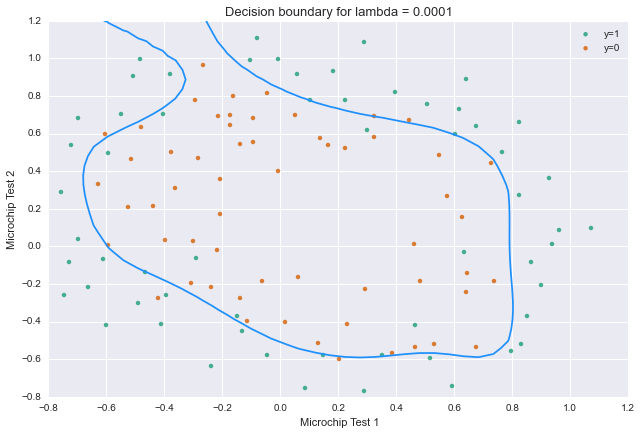

In [89]:
initial_theta = np.zeros(n)
lambda2 = 0.0001
myargs = (X, y, lambda2)
opts = {'full_output': True, 'maxiter':400}

optimal_theta2, cost, grad_at_min, inv_hessian_matrix,\
fun_calls, grad_calls, warn_flags = optimize.fmin_bfgs(cost_function_reg,
                                                      initial_theta,
                                                      args =myargs,
                                                      fprime = gradient,
                                                      **opts)

print '\nCost at theta found by fmin_bfgs:', cost

plot_decision_boundary(optimal_theta2, X, y)

Now let's look at what happens with a larget value for lambda:

[[  8.47457627e-03   1.87880932e-02   7.77711864e-05   5.03446395e-02
    1.15013308e-02   3.76648474e-02   1.83559872e-02   7.32393391e-03
    8.19244468e-03   2.34764889e-02   3.93486234e-02   2.23923907e-03
    1.28600503e-02   3.09593720e-03   3.93028171e-02   1.99707467e-02
    4.32983232e-03   3.38643902e-03   5.83822078e-03   4.47629067e-03
    3.10079849e-02   3.10312442e-02   1.09740238e-03   6.31570797e-03
    4.08503006e-04   7.26504316e-03   1.37646175e-03   3.87936363e-02
    1.99427086e-02   2.74239681e-03   2.32500787e-03   2.21859968e-03
    1.37054473e-03   4.59059364e-03   2.44887343e-03   3.45775396e-02
    2.58470812e-02   9.24073316e-04   3.56449986e-03   2.36431492e-04
    2.73345994e-03   1.41372690e-04   5.06220460e-03   7.44299593e-04
    3.91158180e-02   1.94460178e-02   2.03971305e-03   1.67313910e-03
    9.57374855e-04   8.28510751e-04   1.45754709e-03   5.55440822e-04
    3.80878101e-03   1.42922173e-03   3.74400380e-02   2.27382094e-02
    1.00011095e-03  

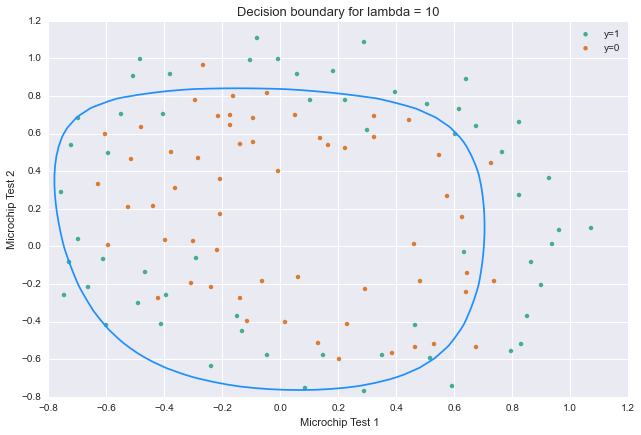

In [90]:
initial_theta = np.zeros(n)
lambda2 = 10
myargs = (X, y, lambda2)
opts = {'full_output': True, 'maxiter': 400}

optimal_theta3, cost, grad_at_min, inv_hessian_matrix,\
fun_calls, grad_calls, warn_flags = optimize.fmin_bfgs(cost_function_reg,
                                initial_theta,
                                args=myargs,
                                fprime=gradient,
                                **opts)

print '\nCost at theta found by fmin_bfgs:', cost

plot_decision_boundary(optimal_theta3, X, y)

![sci-kit learn logo](http://kldavenport.com/scikit-learn-logo.png)

###Regularized Logistic Regression with scikit-learn
What we did above was more verbose than necessary, but could have been worse with Numpy. Bellow we'll work on the same problem from beginning to end with substantially less lines of code

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import seaborn as sns
from ggplot import *

###Loading data

In [92]:
data = pd.read_csv('ex2data2.txt', header=None, names=('x1','x2','y'))
data.info()
# Get the df values into numpy arrays
X = data.ix[:,0:2].values
y = data.ix[:,2].values
y =y #Note we left it as standard 1d array this time

#No need to manually create the first coefficient
# X = np.hstack((np.zeros(shape=(X.shape[0],1)),X))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 3 columns):
x1    118 non-null float64
x2    118 non-null float64
y     118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.7 KB


###Fitting and scoring the Regularized Logistic Regression Model

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

model = LogisticRegression(tol= .0000000000000000001)
model = model.fit(X,y)

#check the accuracy on the training set
model.score(X,y)

0.5423728813559322

54% accuracy is pretty poor performance, let's check out what percentage of chips were labeled "1"(passed the test) below:

In [94]:
y.mean()

0.49152542372881358

49% means that we could have achieved similar performance just by guessing all ones or zeros for our label set. Hold on though, we forgot our feature engineering set. Let's use `new_features` function we defined above to create many new features in X that might capture the non-linear relationship between variable x1 and x2

In [95]:
print 'X shape before:', X.shape
X = new_features(X[:, 0][:, None], X[:, 1][:,None])
print 'X shape after:', X.shape

X shape before: (118L, 2L)
X shape after: (118L, 190L)


Now let's try fitting and scoring the model again:

In [96]:
model = LogisticRegression(tol = .00000000000000000000001)
model = model.fit(X, y)
model.score(X,y)

0.83050847457627119

83% is a marked improvement. Now we can move forward with more standard ML scoring methods. Up to this point we've been using the same set of data to train and score our data. Let's create a train and test set using scikit's handy train_test_split function.

**Cross-Validation Approach**

1. Use the training set.
2. Split it into training/test sets
3. Build a model on the train set
4. Evaluate on the test set
5. Repeat and average the estimated errors

**Used to**

1. Choose variables to include in a model
2. Choose the type of prediction function to use
3. Choose the parameters in the prediction function
4. Compare different predictors

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression(tol= .0000000000000000001)
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=1e-19,
          verbose=0)

In [98]:
predicted = model2.predict(X_test)
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, predicted)

0.861111111111
0.865325077399


We can even try a 10-fold cross-validation to observe how the accuracy changes.

####K-fold CV considerations
 - Larger k = less bias and more variance
 - Smaller k = more bias, less variance

In [99]:
scores = cross_val_score(LogisticRegression(), X ,y, scoring ='accuracy', cv=10)
print scores
print scores.mean()

[ 0.66666667  0.75        0.91666667  0.25        0.66666667  0.66666667
  1.          0.66666667  0.72727273  0.81818182]
0.712878787879


We end up with an average score of 71%. Accuracy doesn't mean the same thing in all cases. Depending on your ML use case certain accuracy metrics might be more important that others. True negatives = Specificity and True Positives = Sensitivity. Much more on this: [here](http://en.wikipedia.org/wiki/Precision_and_recall)

We don't go over more tuning in this post, but there are many opportunities to use scikit's built in grid and random search features to find an optimal tolerance level instead of our arbitrary `tol = .00000000000000000000001`. A quick google search will reveal that there is an incredible amount of work being done just in hyperparameter estimation.

In [100]:
print metrics.confusion_matrix(y_test, predicted)

[[15  4]
 [ 1 16]]


In [101]:
print metrics.classification_report(y_test, predicted)

             precision    recall  f1-score   support

          0       0.94      0.79      0.86        19
          1       0.80      0.94      0.86        17

avg / total       0.87      0.86      0.86        36

